In [1]:

import pandas as pd
from matplotlib import pyplot as plt
from opinionmining import *
from typing import Set
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import itertools
import nltk
from textblob import TextBlob
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet
nltk.download('wordnet')
nltk.download('sentiwordnet')
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import LeaveOneOut, cross_val_predict

# Set save variable
SAVE = False

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jossinger/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/jossinger/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [2]:
def feature_extraction_table(db:pd.DataFrame, filename)->pd.DataFrame:
    # Extract nouns from the database sentences
   
   
    database = db.copy()
    database["ExtractedNouns"] = database["Sentence"].apply(lambda x : FeatureExtraction.categories(x))
    print(f"Nouns extracted")
    #Create a copy of the database to perform feature extraction
    category_table = database.loc[:,"Product_ID":"Sentence_ID"].copy()
    
    
    # Perform Stemming on the sentences
    category_table["Sentence"] = database.Sentence.apply(lambda x: FeatureExtraction.add_negations(x))
    category_table["Stemmed_Sentence"] = category_table.Sentence.apply(lambda x: FeatureExtraction.stemming([x])[0])
    print("Performed Stemming")
    # Remove the stop words
    category_table["Clean_Sentence"] = category_table["Stemmed_Sentence"].apply(lambda x: FeatureExtraction.remove_stop([x])[0])
    print("Stopwords removed")
    
    # Perform fuzzymatching on the least frequently occuring nouns byspliting according to frequency
    flattened_nouns = [item for sublist in database.ExtractedNouns for item in sublist]
    frequency_sorted_nouns = [item for item, count in Counter(flattened_nouns).most_common()]
    midpoint = len(frequency_sorted_nouns)//2
    firsthalf = frequency_sorted_nouns[:midpoint]
    secondhalf = frequency_sorted_nouns[midpoint:] 
    
    # Perform fuzzymatching
    D = FeatureExtraction.fuzzy_match_categories(test_categories=secondhalf, target_categories=firsthalf)
    transactions = list(map(lambda x: FeatureExtraction.fuzzy_match_categories(x, D), database.ExtractedNouns))
    stemmed_transactions = list(map(lambda x: FeatureExtraction.stemming(x), transactions))
    category_table["Stemmed_Transactions"] = stemmed_transactions
    item_set = [lst for lst in stemmed_transactions if len(lst) != 0]
    category_table.head()
    print(f"fuzzy matching done")
    
    # Create a dictionary that remaps stemmed words to most commonly occuring forms of that word
    stemming_tuples = []
    stemming_dict = {}
    for i, l in enumerate(transactions):
        lst = []
        for j, word in enumerate(l):
            original_word = word
            stemmed_word = stemmed_transactions[i][j]
            stemming_tuples.append((stemmed_word, original_word))
    stemming_tuples = sorted(stemming_tuples, key= lambda x: x[0])
    
    # create a key:list pair of all the spellings associated to a stemmed word
    key_valuelists = {k : [] for k, v in stemming_tuples}
    for (key, value) in stemming_tuples:
        try:
            current_list = key_valuelists.get(key)
            current_list.append(value)
            key_valuelists[key] = current_list
        except KeyError as e:
            print(e)
    
    # create the dictionary of the most commonly occuring spelling in each spelling list
    stemming_dict = {k: Counter(v).most_common(1)[0][0] for k, v in key_valuelists.items()}
    print("Stemming Dictionary created")
    
# FREQUENT FEATURE SELECTION via apriori algorithm to determine the most frequent features
# __________________________________________________________________________________________________________________
    d = item_set
    te = TransactionEncoder()
    te_ary = te.fit(d).transform(d)
    df = pd.DataFrame(te_ary, columns = te.columns_)
    frequent_items = apriori(df, min_support=0.01, use_colnames=True) #apriori min support set to 1%
    print("Frequent Features extracted")
    
# FEATURE PRUNING: pruning on sets of compound words where there is a minimum distance between each set of nouns
# __________________________________________________________________________________________________________________
    def compact_distance_between_consecutive_numbers_is_valid(lst:List[int], max_dist=3)->bool:
        # for each permutation calculate the distance between the words, if any of the numbers are larger than 3, continue
        for i in range(len(lst)-1):
            if lst[i+1] - lst[i] > max_dist:
                return False
        return True

    def test_compact_phrase(phrase, sentences):
        # test whether a given phrase is within 2 words of its partner. This is time complexity O(n!), acceptable because max n=3.
        set_words = set(phrase)
        compact_phrase_count = 0
        for sentence in sentences:
            if compact_phrase_count >= 2:
                return True
            sentence_str = sentence.split(" ")
            set_sentence = set(sentence_str)
            if set_words.issubset(set_sentence):
                indicies = [sentence_str.index(word) for word in set_words]
                is_compact = compact_distance_between_consecutive_numbers_is_valid(indicies)
                if is_compact:
                    compact_phrase_count += 1
            else:
                continue
        return False

    test_sents = list(category_table["Stemmed_Sentence"])
    phrases = [phrs for phrs in frequent_items["itemsets"] if len(phrs) >= 2 and len(phrs) < 4]
    single_phrases = [phrs for phrs in frequent_items["itemsets"] if len(phrs) < 2]
    compact_phrases = [ph for ph in phrases if test_compact_phrase(ph, test_sents)]
    print("performed feature pruning on compound phrases")
# PSUPPORT PRUNING: pruning on single words where there the word occurs at least twice outside of a frequent feature 
# __________________________________________________________________________________________________________________
    
    def get_supersets(single_phrase:set, compact_phrases:List[set])->List[set]:
        return [phrase for phrase in compact_phrases if single_phrase.issubset(compact_phrases)]

    def is_valid_noun(ftr, nouns):
        for noun in nouns:
            if ftr == noun.text:
                return True
        return False
                

    def count_sentence(ftr, sentence, feature_phrases):
        # count the number of times ftr appears as a noun 
        # where the sentence does not contain a feature phrase that also contains ftr
        sentence_str = sentence.split(" ")
        sentence_set = set(sentence_str)
        if ftr.issubset(sentence_set):
            doc = nlp(sentence)
            nouns = [token for token in doc if token.pos_ in ["NOUN", "PROPN"]]
            # check if the noun list contains a feature phrase with the same ftr
            super_sets = get_supersets(ftr, compact_phrases=feature_phrases)
            if any(super for super in super_sets if ftr.issubset(super)) and not is_valid_noun(ftr, nouns):
                return 0
            else:
                return 1
        return 0

    def p_support_pruning(single_phrases:List[set], sentences:List[set], compact_phrases:List[set], threshold=3):
        p_support = [0] * len(single_phrases)
        for i, ftr in enumerate(single_phrases):
            for sentence in sentences:
                p_support[i] += count_sentence(ftr, sentence, compact_phrases)
        return [phrase for i, phrase in enumerate(single_phrases) if p_support[i] > threshold]
            
    reduced_single_phrases = p_support_pruning( single_phrases=single_phrases, 
                                                sentences=test_sents, 
                                                compact_phrases=compact_phrases)
    combined_features = reduced_single_phrases + compact_phrases
    print("Performed psupport pruning")
# OPINION WORDS AND EFFECTIVE OPINIONS: pruning on single words where there the word occurs at least twice outside of a frequent feature 
# __________________________________________________________________________________________________________________
   
#    METHODOLOGY 1: Search the surrounding adjectives within some distance = 3
    effective_opinion_sets = []

    features = combined_features
    sentences = category_table.Sentence.apply(lambda x: FeatureExtraction.clean_sentence(x))
    opinion_words = []
    feature_set = [word for feature in features for word in feature]
    for i, sentence in enumerate(sentences):
        try:
            doc = nlp(sentence)
            sentence_set = set(token.text for token in doc)
            sentence_str = [token.text for token in doc]
            op_sets = []
            op_words = []
            for feature in features:
                if feature.issubset(sentence_set):
                    feature_position = sentence_str.index(list(feature)[0])    
                    adjectives = [(feature_position, feature, i, token) for i, token in enumerate(doc) if token.pos_ == "ADJ"]
                    all_adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
                    valid_adjectives = [word for word in all_adjectives if not word in feature_set]
                    op_words.append(valid_adjectives)
                    op_sets.append(adjectives)
            effective_opinion_sets.append(set([tup for op in op_sets for tup in op if len(op) > 0]))
            opinion_words.append(set([w for op in op_words for w in op if len(op) > 0]))
        except Exception as e:
            print(f"Error processing sentence {i}: {e}")

    category_table["Opinion_Words"] = opinion_words



    def get_closest_adjective(ary_sets: Set[Tuple[int, frozenset, int, str]]) -> Set[Tuple[int, frozenset, int, str]]:
        if len(ary_sets) == 0:
            return set()
        # initialize a dictionary
        closest_sets = {}
        for feature_index, feature, adj_index, adj in ary_sets:
            if feature not in closest_sets:
                closest_sets[feature] = (float('inf'), None) 
            # clculate distance between feature and adjective in sentence
            distance = abs(feature_index - adj_index)
            if distance < closest_sets[feature][0]:
                closest_sets[feature] = (distance, (feature_index, feature, adj_index, adj))
        # return the closest adjective n_ary from the dictionary
        return set(value[1] for value in closest_sets.values() if value[1])
    
    # METHODOLOGY 2: only choose the adjectives that are connected to the nouns via amod dependancy
    def get_opinion_words(sentences, frequent_features):
        feature_set = set().union(*frequent_features)
        stemmer = SnowballStemmer("english")
        opinion_words = []
        effective_opinions = []

        for s in sentences:
            doc = nlp(s.lower())
            adjectives = set([token.text for token in doc if token.pos_ == "ADJ"])
            sentence_str = [word.text for word in doc]
            sentence_set = set(sentence_str)
            sentence_effective_adjectives = set()
            # for each feature extract the adjective that modifies the feature
            for ftr in frequent_features:
                if ftr.issubset(sentence_set):
                    indexes = [sentence_str.index(f) for f in ftr]
                    # find the token at the index and search its children for the adjective modifier
                    for index in indexes:
                        for child in doc[index].children:
                            if child.dep_ == "amod" and stemmer.stem(child.text) not in feature_set:
                                sentence_effective_adjectives.add(child.text.replace("_", " "))

            valid_adjectives = set([stemmer.stem(word) for word in adjectives if stemmer.stem(word) not in feature_set])
            

            opinion_words.append(valid_adjectives)
            effective_opinions.append(sentence_effective_adjectives)

        return opinion_words, effective_opinions

# INFREQUENT OPINION SELECTION
# ___________________________________________________________________________________________________________________________
    infreq_opinions = []
    for i, opinion_set in enumerate(effective_opinion_sets):
        s = [t for t in nlp(sentences.to_list()[i])]
        closest_opinion_set = get_closest_adjective(opinion_set)
        op_set = set()
        if closest_opinion_set != set():
            for _, feature, i_adj, adj in closest_opinion_set:
                token = s[i_adj]
                if token.text == adj.text:
                    if token.head.text in feature:
                        continue
                    if token.head.pos_ == "NOUN":
                        op_set.add((adj.text, token.head.text))
        infreq_opinions.append(op_set)
    category_table["Infrequent_Opinions"] = infreq_opinions
    
# FEATURE TAG EXPANSION: expand tags so that they are legible. Do this by finding the most commonly occuring branch of each stem.
# ___________________________________________________________________________________________________________________________
    def phrase_voting(phrases, sentences):
        """
        Perform phrase voting on a given set of phrases that 
        returns the most commonly occuring permutation of a phrase in a set of setnences
        """
        phrase_dict = {k:list(itertools.permutations(k, len(k))) for k in phrases}
        max_perm_dict = {}
        for k, perms in phrase_dict.items():
            counts = [0] * len(perms)
            for sentence in sentences:
                sent_str = sentence.split(" ")
                if set(k).issubset(set(sent_str)):
                    indexes = sorted([sent_str.index(word) for word in k if word in sent_str])
                    ordered_words = [sent_str[i] for i in indexes]
                    for i, perm in enumerate(perms):
                        if tuple(ordered_words) == perm:
                            counts[i] += 1
            max_count_index = counts.index(max(counts))
            max_perm_dict[k] = perms[max_count_index]
        return max_perm_dict

    def map_transaction_tags(stemmed_sentences:List[str], frequent_features: List[Set]):
        sentence_tags = []
        permutation_dictionary = phrase_voting(frequent_features, stemmed_sentences)
        # iterate over the sentences, checking if any frequent feature is a subset of the stemmed sentences
        for i, sentence in enumerate(stemmed_sentences):
            feature_tags = []
            sentence_set, sentence_str = FeatureExtraction.deconstruct_sentence(sentence)
            for feature in frequent_features:
                if feature.issubset(sentence_set):
                    feature = permutation_dictionary[feature]
                    expanded_features = [stemming_dict[f] for f in feature]
                    joined_feature = " ".join(expanded_features)
                    feature_tags.insert(0, joined_feature)
            sentence_tags.append(feature_tags)
        return sentence_tags
    S=category_table.Sentence.to_list()
    opinion_words, effective_opinions = get_opinion_words(sentences=S, frequent_features=combined_features)

# CREATE NEW DATAFRAME WITH NEW INFOMATION 
    # Store all the processed tags in a dataframe
    transaction_tags = database.loc[:,"Product_ID":"Sentence"].copy()
    transaction_tags["Clean_Sentences"] = category_table["Clean_Sentence"]
    transaction_tags["Frequent_Features"] = map_transaction_tags(category_table["Clean_Sentence"].to_list(), combined_features)

    transaction_tags["Classes"] = database["gt_score"].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    transaction_tags["Opinion Words"] = opinion_words
    transaction_tags["Effective_Opinions"] = effective_opinions
    transaction_tags["Infrequent_Features"] = [[" ".join(x) for x in s] for s in infreq_opinions]
    if SAVE:
        transaction_tags.to_csv(filename)
    
# RETURN THE DATAFRAME
    return transaction_tags



# Pipeline 1 - Sentiment Based of Opinion Words and Effective Opinions
Determine Sentiment direction based off the direction of the sample paper

In [3]:
def evaluation(dataframe:pd.DataFrame, name)->pd.DataFrame:
    validations = dataframe.Classes
    predictions = dataframe.Sentiment_Class
    cfm = confusion_matrix(validations, predictions)
    conf_matrix(validations, predictions, cfm)
    accuracy = accuracy_table(validations, predictions, name)
    return accuracy


def sentiment_pipeline_1(dataframe: pd.DataFrame, filename)->Tuple[pd.DataFrame, pd.DataFrame]:
    transaction_tags = dataframe
    def determine_sentiment_on_word_polarity(set_opinion_words, set_effective_opinions, sentence_set):
        # returns 1 if the polarity is positive, 0 if none, and -1 if negative
        opinion_word_score = 0
        effective_opinion_score = 0
        # search through each word set and calculate the polarity of the words individually
        if set_opinion_words:
            for word in set_opinion_words:
                opinion_word_score += determine_polarity_with_negation(word)
        if set_effective_opinions:
            for word in set_effective_opinions:
                effective_opinion_score += determine_polarity_with_negation(word)
        # if the magnitude of the effective opinion score is greater than the opinion score, return whatever the polarity is
        if opinion_word_score == 0 and effective_opinion_score == 0:
            return calculate_sentiment_for_sentence(sentence_set)
        if abs(opinion_word_score) < abs(effective_opinion_score):
            return 1 if effective_opinion_score > 0 else -1
        else:
            total = opinion_word_score + effective_opinion_score
            if total == 0:
                return calculate_sentiment_for_sentence(sentence_set)
            else:
                return 1 if total > 0 else -1

    def determine_polarity_with_negation(word):
        # if theres no word in the set, return 0
        if word is None:
            return 0
        # if the wordset contains a negation, determine the polarity of the word and invert value
        if "not " in word:
            word = word.replace("not ", "")
            sentiment = get_sentiment(word)
            return -sentiment
        return get_sentiment(word)
        

    def get_antonym(word):
        antonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.antonyms():
                    antonyms.update(antonym.name() for antonym in lemma.antonyms())
        return antonyms 

    def get_sentiment(word):
        senti_synonyms = list(sentiwordnet.senti_synsets(word))
        if senti_synonyms:
            sentiment = calculate_sentiment(senti_synonyms)
            if sentiment != 0:
                return sentiment

        antonyms = get_antonym(word) 
        if antonyms:
            senti_antonyms = [senti_synset for antonym in antonyms for senti_synset in list(sentiwordnet.senti_synsets(antonym))]
            if senti_antonyms:
                sentiment = calculate_sentiment(senti_antonyms) * -1
                return sentiment
        return 0
        
        
    def calculate_sentiment(synset):
        neg_scores = sum([s.neg_score() for s in synset])
        pos_scores = sum([s.pos_score() for s in synset])
        if neg_scores > pos_scores:
            return -1 
        elif pos_scores > neg_scores:
            return 1   
        else:
            return 0
        
    def calculate_sentiment_for_sentence(sentence):
        score = sum([get_sentiment(word) for word in sentence])
        if score == 0:
            s = " ".join(sentence)
            score = TextBlob(s).sentiment.polarity
        if score >= 0:
            return 1
        if score < 0:
            return -1    

    # seperate out those sentences that are setiment bearing - they have opinion words or effective opinions that directly influence the nouns and noun phrases
    df = transaction_tags.copy()
    # remove classes that have no classification
    opinion_bearing_table = df[(df["Classes"]!=0)]
    opinion_bearing_table.reset_index(drop=True, inplace=True)
    op_words = opinion_bearing_table["Opinion Words"].values
    ef_op_words = opinion_bearing_table["Effective_Opinions"].values
    sentences = opinion_bearing_table["Sentence"].map(lambda x: set([w.lower() for w in x.split(" ")]))
    # perform the sentiment classification
    opinion_bearing_table["Sentiment_Class"] = [determine_sentiment_on_word_polarity(op_words[i], ef_op_words[i], sentences[i]) for i in range(len(op_words))]
    return opinion_bearing_table, evaluation(opinion_bearing_table, "Lexicographic Sentiment")


def sentiment_pipeline_2(dataframe: pd.DataFrame, name)->Tuple[pd.DataFrame, pd.DataFrame]:
    # remove those sentences that are not tagged as positive or negative
    opinion_bearing_table = dataframe.copy().where(dataframe.Classes != 0).dropna()
    X = opinion_bearing_table["Clean_Sentences"].to_list()
    y = opinion_bearing_table["Classes"].to_list()
    # perform pipeline with binary count vectorization using naive bayes and leave-one-out cross validation.
    pipe = Pipeline([('vectorizer', CountVectorizer(binary=True)), ('naivebayes', MultinomialNB())])
    opinion_bearing_table["Sentiment_Class"] = cross_val_predict(pipe, X, y, cv=LeaveOneOut())
    return opinion_bearing_table, evaluation(opinion_bearing_table, "Naive Bayes")
    
    

In [4]:
def get_paths():
    paths = []
    for folder in os.listdir(full_path):
        try:
            for file in os.listdir(os.path.join(full_path, folder)):
                if str(file) != "Readme.txt" and str(file) != ".DS_Store":
                    paths.append(os.path.join(full_path, folder, file))
        except NotADirectoryError:
            continue
    return paths


def write_database(paths):
    pwd = os.getcwd()
    filename = "db.csv"
    if SAVE:
        db = ReviewDatabase(paths).dataframe.to_csv(os.path.join(pwd, filename))
        db = pd.read_csv(filename)
    else:
        db = pd.read_csv(filename)
    return db
        
def get_product_database(db, product_name):
    return db.where(db["Product_name"] == product_name).copy().dropna()

def run_pipeline(n = 10, pipeline=sentiment_pipeline_2):
    paths = get_paths()
    db = write_database(paths)
    sentiment_db = pd.DataFrame()
    product_names = sorted(set(db["Product_name"]))
    print(product_names)
    for i in range(0, n):
        name = product_names[i]
        database = get_product_database(db=db, product_name=name)
        print(f"\nproduct: {name.upper()}\n___________________________________________________________________________________________________")
        feature_database = feature_extraction_table(database, name)
        opinion_table, evaluation_table = pipeline(feature_database, name)
        sentiment_db = pd.concat([sentiment_db, opinion_table])
        print("\nEVALUATION TABLE:\n")
        display(evaluation_table)
    sentiment_db.to_csv("sentiment_classifications.csv")
run_pipeline(pipeline=sentiment_pipeline_2)


        



In [5]:
paths = get_paths()
db = write_database(paths)
sentiment_db = pd.DataFrame()
name = "norton"
database = get_product_database(db=db, product_name=name)
print(f"\nproduct: {name.upper()}\n___________________________________________________________________________________________________")
feature_database = feature_extraction_table(database, name)



product: NORTON
___________________________________________________________________________________________________
Nouns extracted
Performed Stemming
Stopwords removed
fuzzy matching done
Stemming Dictionary created
Frequent Features extracted
performed feature pruning on compound phrases
Performed psupport pruning


(203,)
(203,)


/var/folders/42/qsqz6yz9635dllwfh9y5csxm0000gn/T/ipykernel_57504/1445353535.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opinion_bearing_table["Sentiment_Class"] = [determine_sentiment_on_word_polarity(op_words[i], ef_op_words[i], sentences[i]) for i in range(len(op_words))]


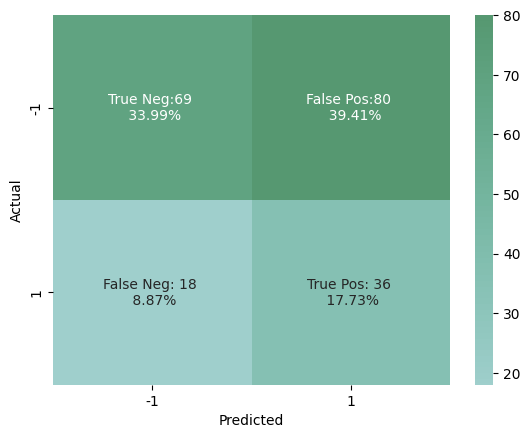

In [6]:
opinion_table, eval= sentiment_pipeline_1(feature_database, name)